In [175]:
# Cell 1: imports & helper functions

import numpy as np

# 固定随机种子，方便复现
rng = np.random.default_rng(42)

# ===================== QAM 相关函数 ===================== #

def qam_constellation(M: int) -> np.ndarray:
    """
    生成正方形 M-QAM 星座，平均功率归一化为 1
    使用自然二进制映射（不是 Gray 码）
    返回: 复数 numpy 数组，shape [M,]
    """
    m_side = int(np.sqrt(M))
    if m_side ** 2 != M:
        raise ValueError("Only square QAM is supported (4,16,64,256,...)")

    # 一维坐标: -(m_side-1),..., -1,1,...,(m_side-1)
    re_im_vals = np.arange(-(m_side - 1), m_side, 2)
    xv, yv = np.meshgrid(re_im_vals, re_im_vals)
    const = xv + 1j * yv  # 笛卡尔积
    const = const.flatten()

    # 归一化平均功率为 1
    const_power = np.mean(np.abs(const) ** 2)
    const /= np.sqrt(const_power)
    return const


def bits_to_int(bits: np.ndarray) -> np.ndarray:
    """
    将末轴为 bit 的数组转为整数（MSB 优先）
    bits: shape [..., n_bits]
    返回: shape [...]
    """
    bits = np.asarray(bits).astype(np.int8)
    n_bits = bits.shape[-1]
    weights = 1 << np.arange(n_bits - 1, -1, -1)  # [2^(n-1),...,1]
    return np.sum(bits * weights, axis=-1)


def int_to_bits(vals: np.ndarray, n_bits: int) -> np.ndarray:
    """
    将整数数组转为 bit 数组，MSB 优先
    vals: shape [N,]
    返回: shape [N, n_bits]
    """
    vals = np.asarray(vals).astype(np.int64)
    bits = (((vals[:, None] & (1 << np.arange(n_bits - 1, -1, -1))) > 0)
            .astype(np.int8))
    return bits


def qam_mod(bits: np.ndarray, M: int) -> np.ndarray:
    """
    QAM 调制
    bits: shape [N_bits,]
    返回: 复数符号数组，shape [N_sym,]
    """
    bits = np.asarray(bits).astype(np.int8)
    bits_per_sym = int(np.log2(M))
    if bits.size % bits_per_sym != 0:
        raise ValueError("Number of bits must be multiple of log2(M).")
    const = qam_constellation(M)
    bit_groups = bits.reshape(-1, bits_per_sym)
    idx = bits_to_int(bit_groups)
    syms = const[idx]
    return syms


def qam_demod(syms: np.ndarray, M: int) -> np.ndarray:
    """
    QAM 解调（最小距离硬判决）
    syms: shape [N_sym,]
    返回: bits，shape [N_sym*log2(M),]
    """
    syms = np.asarray(syms)
    const = qam_constellation(M)
    bits_per_sym = int(np.log2(M))

    # 距离矩阵: [N_sym, M]
    dist2 = np.abs(syms[:, None] - const[None, :]) ** 2
    idx_hat = np.argmin(dist2, axis=1)
    bits_block = int_to_bits(idx_hat, bits_per_sym)
    return bits_block.reshape(-1)


# ===================== 压缩算法（逐 block） ===================== #

def compress_bs_block(y: np.ndarray, qbits: int) -> np.ndarray:
    """
    Block Scaling (BS) 压缩，严格对应论文 (8)-(10) 的等价形式：
      - 对 block 内所有复数样本 y_i，取 max_val = max |y_i|
      - 令 max_int = 2^(qbits-1) - 1  (≈ L/2 - 1)
      - S = max_val / max_int
      - 对实部、虚部分别做：int = round( value / S )，clip到 [-max_int, max_int]
      - 重构: value_hat = int * S
    """
    y = np.asarray(y)
    y_hat = np.zeros_like(y, dtype=np.complex128)
    if y.size == 0:
        return y_hat

    # 关键：用复数模长，而不是拼接 Re/Im 后取 max
    max_val = np.max(np.abs(y))
    if max_val == 0:
        return y_hat

    max_int = (1 << (qbits - 1)) - 1  # e.g. qbits=4 → max_int = 7
    S = max_val / max_int            # scale so that max |y| → ±max_int

    re = np.real(y)
    im = np.imag(y)

    # 实部
    re_n = re / S
    re_q = np.round(re_n)
    re_q = np.clip(re_q, -max_int, max_int)
    re_hat = re_q * S

    # 虚部
    im_n = im / S
    im_q = np.round(im_n)
    im_q = np.clip(im_q, -max_int, max_int)
    im_hat = im_q * S

    y_hat = re_hat + 1j * im_hat
    return y_hat


import numpy as np
import math


def bfp_compression(data: np.ndarray, bit_width: int, mod_order: int):
    """
    Python 版 BFP 压缩，实现方式与 Matlab 版本对齐。

    参数
    ----
    data : np.ndarray
        待压缩数据，可以是实数或复数，一维或多维。
    bit_width : int
        每个样本压缩后的总比特数（exponent + mantissa）。
    mod_order : int
        调制阶数（2=QPSK, 16=16QAM, 64=64QAM），用于决定 block size。

    返回
    ----
    compressed : np.ndarray
        压缩-解压后的近似数据（与 data 形状一致）。
    CR : float
        压缩比 Compression Ratio = 原始比特数 / 压缩后比特数
    """
    data = np.asarray(data)

    # ===== 1) block 大小与调制阶数对应 =====
    if mod_order == 2:          # QPSK
        block_size = 64
    elif mod_order == 16:       # 16-QAM
        block_size = 32
    elif mod_order == 64:       # 64-QAM
        block_size = 16
    else:
        raise ValueError(f"Unsupported modulation order: {mod_order}")

    # ===== 2) exponent / mantissa 比特宽度划分 =====
    exponent_bit_width = math.ceil(0.3 * bit_width)
    mantissa_bit_width = bit_width - exponent_bit_width

    # ===== 3) 调用 process_component =====
    compressed, metadata_bits = _process_component(
        data=data,
        block_size=block_size,
        exponent_bit_width=exponent_bit_width,
        mantissa_bit_width=mantissa_bit_width,
    )

    # ===== 4) 计算压缩比 CR（与 Matlab 保持一致）=====
    original_bit_width = 32  # 假定原始样本为 32-bit（float）
    original_size = data.size * original_bit_width
    compressed_size = compressed.size * bit_width + metadata_bits
    CR = original_size / compressed_size

    return compressed, CR


def _process_component(
    data: np.ndarray,
    block_size: int,
    exponent_bit_width: int,
    mantissa_bit_width: int,
):
    """
    与 Matlab `process_component` 对齐的核心 BFP 实现。

    - 按 block_size 分块；
    - 每块计算 blockMax → blockExponent（整数，按 exponent_bit_width 饱和）；
    - scaleFactor = 2^{-blockExponent}；
    - 量化：round((block * scaleFactor) * maxLevel) / maxLevel；
    - 小于 threshold 的值置零；
    - 最终除以 scaleFactor 还原。

    支持复数 data：round/abs 在 numpy 中会分别作用于实部/虚部/模。
    """
    data = np.asarray(data)
    flat = data.ravel()  # 先扁平化处理，最后再 reshape 回原来形状
    n = flat.size

    num_blocks = int(np.ceil(n / block_size))
    compressed_flat = np.zeros_like(flat, dtype=np.complex128)

    # 元数据：每个 block 存一个 exponent
    metadata_bits = num_blocks * exponent_bit_width

    # mantissa 相关参数
    max_level = 2 ** (mantissa_bit_width - 1) - 1
    threshold = 2.0 ** (-mantissa_bit_width)

    eps = np.finfo(float).eps

    # exponent 饱和值
    e_min = - (2 ** (exponent_bit_width - 1))
    e_max = (2 ** (exponent_bit_width - 1)) - 1

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min((block_idx + 1) * block_size, n)

        block = flat[start_idx:end_idx]

        # ---- 1) 计算该块的最大幅度 ----
        block_max = np.max(np.abs(block))
        if block_max < eps:
            # 这一块全 0，直接保持为 0
            compressed_flat[start_idx:end_idx] = 0
            continue

        # ---- 2) 计算整数指数并饱和 ----
        # Matlab: blockExponent = ceil(log2(blockMax + eps));
        block_exponent = int(np.ceil(np.log2(block_max + eps)))
        block_exponent = max(e_min, min(block_exponent, e_max))

        # ---- 3) scaleFactor = 2^{-e} ----
        scale_factor = 2.0 ** (-block_exponent)

        # ---- 4) 缩放后量化 mantissa ----
        # tmp ≈ mantissa（实/虚部都被缩放到[-1,1]附近）
        tmp = block * scale_factor

        # Matlab: quantizedBlock = round(tmp * maxLevel) / maxLevel;
        quantized_block = np.round(tmp * max_level) / max_level

        # ---- 5) 小值阈值化为 0 ----
        # Matlab: quantizedBlock(abs(quantizedBlock) < threshold) = 0;
        mask_small = np.abs(quantized_block) < threshold
        quantized_block[mask_small] = 0.0

        # ---- 6) 还原尺度并存储 ----
        compressed_flat[start_idx:end_idx] = quantized_block / scale_factor

    # reshape 回原始形状
    compressed = compressed_flat.reshape(data.shape)
    return compressed, metadata_bits



def compress_mulaw_block(y: np.ndarray, qbits: int, mu: float = 8.0) -> np.ndarray:
    """
    μ-law 压缩 (per-block, per-I/Q) —— 对齐论文结构：

      - A = max |y_i|  (复数模长)
      - 归一化:  y_n = y / A
      - compand: F(y_n) = sgn(y_n)*ln(1+μ|y_n|)/ln(1+μ)
      - 在 [-1,1] 内用 2^qbits 个等级均匀量化 F(y_n)
      - expand: 反 μ-law
      - 反归一化: y_hat = y_hat_n * A
    """
    y = np.asarray(y)
    y_hat = np.zeros_like(y, dtype=np.complex128)
    if y.size == 0:
        return y_hat

    # ---- block 最大幅度：使用复数模长 ----
    max_val = np.max(np.abs(y))
    if max_val == 0:
        return y_hat

    # ---- 归一化到 [-1,1] ----
    re_n = np.real(y) / max_val
    im_n = np.imag(y) / max_val

    # ---- μ-law compand ----
    def compand(x):
        s = np.sign(x)
        a = np.abs(x)
        return s * (np.log(1 + mu * a) / np.log(1 + mu))

    re_c = compand(re_n)
    im_c = compand(im_n)

    # ---- m-bit 均匀量化 in [-1,1] ----
    L = 1 << qbits                 # 2^qbits
    delta_c = 2.0 / (L - 1)        # 步长

    re_q = np.round(re_c / delta_c) * delta_c
    im_q = np.round(im_c / delta_c) * delta_c

    re_q = np.clip(re_q, -1.0, 1.0)
    im_q = np.clip(im_q, -1.0, 1.0)

    # ---- μ-law expand ----
    def expand(xc):
        s = np.sign(xc)
        a = np.abs(xc)
        return s * (((1 + mu) ** a - 1) / mu)

    re_hat_n = expand(re_q)
    im_hat_n = expand(im_q)

    # ---- 反归一化 ----
    re_hat = re_hat_n * max_val
    im_hat = im_hat_n * max_val

    y_hat = re_hat + 1j * im_hat
    return y_hat



def compress_uniform_block(y: np.ndarray, qbits: int) -> np.ndarray:
    """
    Uniform 量化 (per-block, per-I/Q) —— 对齐论文思路：

      1) 对 block 内所有复数样本 y_i，令 A = max |y_i|
      2) 在实数区间 [-A, A] 上用 L = 2^qbits 个等级做均匀量化
      3) 对实部/虚部分别量化：
           Δ = 2A / L
           idx = floor(x / Δ) + 0.5
           idx_clip = clip(idx, -(2^qbits) - 0.5, 2^qbits - 0.5)
           x_hat = Δ * idx_clip
      4) 还原成复数 y_hat = re_hat + j im_hat
    """
    y = np.asarray(y)
    y_hat = np.zeros_like(y, dtype=np.complex128)
    if y.size == 0:
        return y_hat

    # ---- 1) Block 动态范围：用复数模长定义 A ----
    A = np.max(np.abs(y))
    if A == 0:
        return y_hat

    # ---- 2) 步长 Δ 与等级数 L ----
    m = qbits
    L = 1 << m           # 2^m
    Delta = 2.0 * A / L  # 区间 [-A,A] 被切成 L 段

    re = np.real(y)
    im = np.imag(y)

    def quantize_uniform_1d(x):
        # 将 x 映射到整数 index
        idx = np.floor(x / Delta) + 0.5
        # clip 范围参照 O-RAN 常见实现（对称）
        low = -(2**m) - 0.5
        high = (2**m) - 0.5
        idx = np.clip(idx, low, high)
        # 重构值：bin 中心
        return Delta * idx

    re_hat = quantize_uniform_1d(re)
    im_hat = quantize_uniform_1d(im)

    y_hat = re_hat + 1j * im_hat
    return y_hat


In [176]:
# Cell 2: 测试 QAM mod/demod 正确性

M_mod_list = [4, 16, 64, 256]

for M in M_mod_list:
    bits_per_sym = int(np.log2(M))
    N_sym_test = 1000

    # 随机比特
    bits_tx = rng.integers(0, 2, size=N_sym_test * bits_per_sym, dtype=np.int8)

    # 调制 → 解调
    syms = qam_mod(bits_tx, M)
    bits_rx = qam_demod(syms, M)

    n_err = np.sum(bits_tx != bits_rx)
    print(f"M={M}: total bits={bits_tx.size}, errors={n_err}")


M=4: total bits=2000, errors=0
M=16: total bits=4000, errors=0
M=64: total bits=6000, errors=0
M=256: total bits=8000, errors=0


In [177]:
# Cell 3: 测试四种压缩算法在一个随机向量上的效果

N_test = 64
qbits_test = 4

# 随机复高斯向量
y = (rng.normal(size=N_test) + 1j * rng.normal(size=N_test)) / np.sqrt(2)

y_bs  = compress_bs_block(y, qbits_test)

# ---- 使用新的 bfp_compression 函数（这里先假定 QPSK → mod_order=2）----
y_bfp, CR_bfp = bfp_compression(
    data=y,
    bit_width=qbits_test,
    mod_order=2  # QPSK
)

y_mu  = compress_mulaw_block(y, qbits_test, mu=8.0)
y_uni = compress_uniform_block(y, qbits_test)

def mse(x, y):
    return np.mean(np.abs(x - y)**2)

print("MSE vs 原始 y:")
print(f"  BS     : {mse(y, y_bs):.4e}")
print(f"  BFP    : {mse(y, y_bfp):.4e}")
print(f"  mu-law : {mse(y, y_mu):.4e}")
print(f"  Uniform: {mse(y, y_uni):.4e}")

print(f"\nBFP Compression Ratio (CR) on random vector: {CR_bfp:.3f}")

print("\n前 5 个样本对比 (原始 / BS / BFP / mu / Uni):")
for i in range(5):
    print(f"i={i}: y={y[i]: .3f}, BS={y_bs[i]: .3f}, "
          f"BFP={y_bfp[i]: .3f}, mu={y_mu[i]: .3f}, Uni={y_uni[i]: .3f}")

MSE vs 原始 y:
  BS     : 1.2657e-02
  BFP    : 5.6606e-01
  mu-law : 1.1370e-02
  Uniform: 9.1183e-03

BFP Compression Ratio (CR) on random vector: 7.938

前 5 个样本对比 (原始 / BS / BFP / mu / Uni):
i=0: y=-0.266-0.425j, BS=-0.276-0.553j, BFP= 0.000+0.000j, mu=-0.340-0.340j, Uni=-0.363-0.363j
i=1: y=-0.324+1.207j, BS=-0.276+1.105j, BFP= 0.000+2.000j, mu=-0.340+1.160j, Uni=-0.363+1.088j
i=2: y= 0.544+0.153j, BS= 0.553+0.276j, BFP= 0.000+0.000j, mu= 0.539+0.193j, Uni= 0.604+0.121j
i=3: y= 0.579+0.569j, BS= 0.553+0.553j, BFP= 0.000+0.000j, mu= 0.539+0.539j, Uni= 0.604+0.604j
i=4: y=-0.378+0.087j, BS=-0.276+0.000j, BFP= 0.000+0.000j, mu=-0.340+0.082j, Uni=-0.363+0.121j


In [178]:
# Cell 4: 设置场景 (共址 MIMO / Cell-free) 与仿真参数

# ========= 选择场景类型 =========
# "mimo"    : 单小区共址 MIMO（原来的 DD-MIMO / co-located）
# "cellfree": Cell-free 场景（L 个 AP 分布在平面上，每个 AP 一根天线）
scenario_type = "cellfree"   # 可改为 "mimo"

# ========= 公共参数 =========
K_UE = 2              # UE 数量
N_sym_per_TB = 144    # 每个 UE 每个 TB 的符号数 (e.g., 12 PRB * 12 RE)

# 天线 / RU / AP 数目
if scenario_type == "mimo":
    # 单基站，M_RU 根共址天线
    M_RU = 8
    scenario_name = f"Co-located MIMO (M={M_RU}, K={K_UE})"
elif scenario_type == "cellfree":
    # L = M_RU 个 AP，每个 AP 1 根天线（典型 CF 场景）
    M_RU = 8
    scenario_name = f"Cell-free (L={M_RU} APs, K={K_UE} UEs)"
else:
    raise ValueError("scenario_type must be 'mimo' or 'cellfree'")

# ========= 选择 MCS（决定 QAM 阶数 + 压缩 bit 数） =========
# 1=QPSK, 2=16QAM, 3=64QAM, 4=256QAM
mcs = 2

if mcs == 1:
    M_mod = 4
    name_mod = "QPSK"
    CW_bits = 2
elif mcs == 2:
    M_mod = 16
    name_mod = "16QAM"
    CW_bits = 4
elif mcs == 3:
    M_mod = 64
    name_mod = "64QAM"
    CW_bits = 5
elif mcs == 4:
    M_mod = 256
    name_mod = "256QAM"
    CW_bits = 6
else:
    raise ValueError("Unknown MCS")

bits_per_sym = int(np.log2(M_mod))
bits_per_TB = N_sym_per_TB * bits_per_sym

print(f"Scenario   : {scenario_name}")
print(f"Modulation : {name_mod}, bits_per_sym={bits_per_sym}, "
      f"bits_per_TB={bits_per_TB}, CW_bits={CW_bits}")

# ========= SNR 扫描 =========
SNRdB_vec = np.arange(90, 110, 4)  # 4,8,...,28 dB
print("SNRdB_vec :", SNRdB_vec)

# Monte Carlo 次数（完整仿真时再改大）
Ntrials = 50   # 先用小一点，方便调试

algo_names = [
    "No compression",
    "Block Scaling (BS)",
    "Block Floating Point (BFP)",
    "mu-law",
    "Uniform"
]
N_algo = len(algo_names)

# ========= Cell-free 场景下的几何与大尺度衰落 =========
# 在 MIMO 模式下，我们先保持和之前一样：只用 i.i.d. Rayleigh（等效 beta=1）
# 在 cell-free 模式下，我们生成 AP/UE 位置与 beta(m,k)，在 Cell 6 用来缩放小尺度系数

cf_params = None

if scenario_type == "cellfree":
    # 区域大小（单位：米），简单设一个正方形小区
    area_size = 100.0

    # AP 在 [0, area_size]^2 内均匀分布
    ap_pos = rng.uniform(0.0, area_size, size=(M_RU, 2))  # [M_RU, 2]

    # UE 也在同一区域内随机分布（你也可以固定一个 geometry 做多 SNR 扫描）
    ue_pos = rng.uniform(0.0, area_size, size=(K_UE, 2))  # [K_UE, 2]

    # 路径损耗模型: beta(d) = beta0 * (d/d0)^(-alpha)
    d0 = 1.0      # 参考距离 (m)
    alpha_pl = 3.7
    beta0_dB = -30.0   # 1 m 处的平均大尺度增益 (dB)

    # 计算 AP-UE 距离矩阵 d[m,k]
    # ap_pos: [M_RU,2], ue_pos: [K_UE,2]
    d = np.linalg.norm(ap_pos[:, None, :] - ue_pos[None, :, :], axis=2)  # [M_RU, K_UE]
    d = np.maximum(d, d0)  # 避免距离为 0

    # dB 域的大尺度衰落
    beta_dB = beta0_dB - 10 * alpha_pl * np.log10(d / d0)
    # 转到线性域：|h_small|^2 的平均值会乘上 beta_lin
    beta_lin = 10 ** (beta_dB / 10.0)  # [M_RU, K_UE]

    cf_params = dict(
        ap_pos=ap_pos,
        ue_pos=ue_pos,
        beta_lin=beta_lin,
        area_size=area_size,
        alpha_pl=alpha_pl,
        beta0_dB=beta0_dB,
        d0=d0
    )

    print("Cell-free geometry generated:")
    print("  AP positions shape:", ap_pos.shape)
    print("  UE positions shape:", ue_pos.shape)
    print("  beta_lin shape    :", beta_lin.shape)

else:
    print("MIMO co-located mode: using i.i.d. Rayleigh (no large-scale fading yet).")


Scenario   : Cell-free (L=8 APs, K=2 UEs)
Modulation : 16QAM, bits_per_sym=4, bits_per_TB=576, CW_bits=4
SNRdB_vec : [ 90  94  98 102 106]
Cell-free geometry generated:
  AP positions shape: (8, 2)
  UE positions shape: (2, 2)
  beta_lin shape    : (8, 2)


In [179]:
# Cell 5: 单个 SNR & 单次 trial 的详细检查

SNRdB = 100
SNRlin = 10 ** (SNRdB / 10.0)
tx_symbol_power = 1.0  # 调制星座归一化
noise_var = tx_symbol_power / SNRlin

print(f"SNRdB={SNRdB}, noise_var={noise_var:.4e}")

# 1) 生成比特 & QAM 调制
bits_tx = rng.integers(0, 2, size=(K_UE, bits_per_TB), dtype=np.int8)      # [K_UE, bits_per_TB]
print("bits_tx shape:", bits_tx.shape)

s_tx = np.zeros((N_sym_per_TB, K_UE), dtype=complex)                       # [N_sym, K_UE]
for k in range(K_UE):
    syms_k = qam_mod(bits_tx[k], M_mod)
    s_tx[:, k] = syms_k

print("s_tx shape:", s_tx.shape)

# 2) 生成信道 + 噪声
if scenario_type == "cellfree" and cf_params is not None:
    beta_lin = cf_params["beta_lin"]  # [M_RU, K_UE]
    # 小尺度: i.i.d. Rayleigh, 再乘 sqrt(beta_lin) 做大尺度缩放
    H_small = (rng.normal(size=(N_sym_per_TB, M_RU, K_UE)) +
               1j * rng.normal(size=(N_sym_per_TB, M_RU, K_UE))) / np.sqrt(2)
    H = H_small * np.sqrt(beta_lin[None, :, :])  # [N_sym, M_RU, K_UE]
else:
    # 原来的共址 MIMO 模型：不带大尺度衰落的 Rayleigh
    H = (rng.normal(size=(N_sym_per_TB, M_RU, K_UE)) +
         1j * rng.normal(size=(N_sym_per_TB, M_RU, K_UE))) / np.sqrt(2)
print("H shape:", H.shape)   # [N_sym, M_RU, K_UE]

Y = np.zeros((N_sym_per_TB, M_RU), dtype=complex)  # [N_sym, M_RU]
for n in range(N_sym_per_TB):
    g_n = H[n]          # [M_RU, K_UE]
    s_n = s_tx[n]       # [K_UE,]
    y_n = g_n @ s_n     # [M_RU,]
    noise = (rng.normal(size=M_RU) + 1j * rng.normal(size=M_RU)) * np.sqrt(noise_var / 2)
    Y[n] = y_n + noise

print("Y shape:", Y.shape)

# 转成 [M_RU, N_sym] 方便“逐 RU 逐 block 压缩”
Y_T = Y.T
print("Y_T shape:", Y_T.shape)

# 3) 对第一个 RU、前 16 个符号测试四种压缩
test_vec = Y_T[0, :16]
print("test_vec shape:", test_vec.shape)

test_bs  = compress_bs_block(test_vec, CW_bits)

# ---- 为 BFP 选择对应的 mod_order ----
if M_mod == 4:
    mod_order_bfp = 2      # QPSK
elif M_mod == 16:
    mod_order_bfp = 16     # 16QAM
elif M_mod == 64:
    mod_order_bfp = 64     # 64QAM
else:
    # 256QAM 的情况，目前 Matlab 版本没有定义；
    # 可以先退化用 64QAM 的设置，或直接 raise。
    mod_order_bfp = 64

test_bfp, CR_bfp_local = bfp_compression(
    data=test_vec,
    bit_width=CW_bits,
    mod_order=mod_order_bfp
)

test_mu  = compress_mulaw_block(test_vec, CW_bits, mu=8.0)
test_uni = compress_uniform_block(test_vec, CW_bits)

print(f"\nBFP local CR on test_vec: {CR_bfp_local:.3f}")

print("\nCompression sanity check on first 4 entries:")
for i in range(4):
    print(f"i={i}: orig={test_vec[i]: .3f}, BS={test_bs[i]: .3f}, "
          f"BFP={test_bfp[i]: .3f}, mu={test_mu[i]: .3f}, Uni={test_uni[i]: .3f}")

# 4) 单种算法下的 MMSE 合并 + 解调（以 No compression 为例）
Y_use_T = Y_T.copy()  # 不压缩

bits_hat = np.zeros((K_UE, bits_per_TB), dtype=np.int8)

for n in range(N_sym_per_TB):
    g_n = H[n]            # [M_RU, K_UE]
    y_n = Y_use_T[:, n]   # [M_RU,]

    # MMSE: R = G G^H + sigma^2 I, W = R^{-1} G
    R = g_n @ g_n.conj().T + noise_var * np.eye(M_RU)
    W = np.linalg.solve(R, g_n)  # [M_RU, K_UE]
    x_hat = W.conj().T @ y_n     # [K_UE,]

    for k in range(K_UE):
        sym_hat = x_hat[k]
        bits_demod_k = qam_demod(np.array([sym_hat]), M_mod)
        start = n * bits_per_sym
        end = start + bits_per_sym
        bits_hat[k, start:end] = bits_demod_k

print("\nbits_hat shape:", bits_hat.shape)

for k in range(K_UE):
    n_err = np.sum(bits_hat[k] != bits_tx[k])
    print(f"UE{k}: bit errors = {n_err} / {bits_per_TB}")


SNRdB=100, noise_var=1.0000e-10
bits_tx shape: (2, 576)
s_tx shape: (144, 2)
H shape: (144, 8, 2)
Y shape: (144, 8)
Y_T shape: (8, 144)
test_vec shape: (16,)

BFP local CR on test_vec: 7.758

Compression sanity check on first 4 entries:
i=0: orig= 0.000-0.000j, BS= 0.000-0.000j, BFP= 0.000+0.000j, mu= 0.000-0.000j, Uni= 0.000-0.000j
i=1: orig=-0.000+0.000j, BS=-0.000+0.000j, BFP= 0.000+0.000j, mu=-0.000+0.000j, Uni=-0.000+0.000j
i=2: orig= 0.000+0.000j, BS= 0.000+0.000j, BFP= 0.000+0.000j, mu= 0.000+0.000j, Uni= 0.000+0.000j
i=3: orig= 0.000-0.000j, BS= 0.000-0.000j, BFP= 0.000+0.000j, mu= 0.000-0.000j, Uni= 0.000-0.000j

bits_hat shape: (2, 576)
UE0: bit errors = 1 / 576
UE1: bit errors = 0 / 576


Simulating 16QAM, CW_bits=4, M=8, K=2, Ntrials=50, scenario=cellfree
SNR=90 dB | No compression=1.000, Block Scaling (BS)=1.000, Block Floating Point (BFP)=1.000, mu-law=1.000, Uniform=1.000
SNR=94 dB | No compression=0.920, Block Scaling (BS)=0.990, Block Floating Point (BFP)=1.000, mu-law=0.920, Uniform=0.960
SNR=98 dB | No compression=0.520, Block Scaling (BS)=0.630, Block Floating Point (BFP)=1.000, mu-law=0.580, Uniform=0.640
SNR=102 dB | No compression=0.120, Block Scaling (BS)=0.440, Block Floating Point (BFP)=1.000, mu-law=0.340, Uniform=0.340
SNR=106 dB | No compression=0.000, Block Scaling (BS)=0.160, Block Floating Point (BFP)=1.000, mu-law=0.060, Uniform=0.090


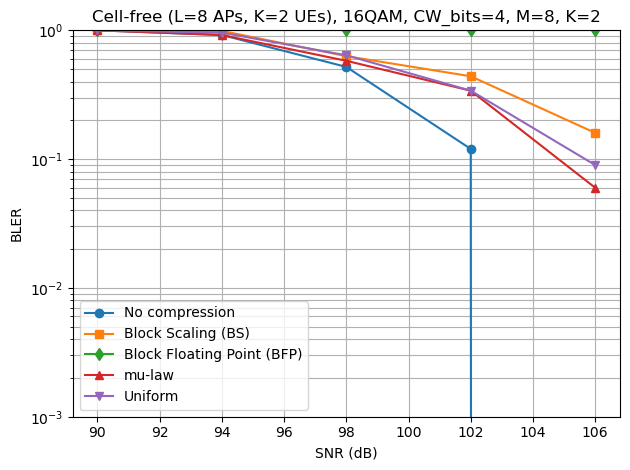

In [180]:
# Cell 6: 完整 BLER 仿真 + 绘图

import matplotlib.pyplot as plt

BLER = np.zeros((N_algo, len(SNRdB_vec)), dtype=float)
tx_symbol_power = 1.0

print(f"Simulating {name_mod}, CW_bits={CW_bits}, M={M_RU}, K={K_UE}, "
      f"Ntrials={Ntrials}, scenario={scenario_type}")

for iSNR, SNRdB in enumerate(SNRdB_vec):
    SNRlin = 10 ** (SNRdB / 10.0)
    noise_var = tx_symbol_power / SNRlin

    blk_err_cnt = np.zeros(N_algo, dtype=int)

    for _ in range(Ntrials):
        # 1) bits & QAM
        bits_tx = rng.integers(0, 2, size=(K_UE, bits_per_TB), dtype=np.int8)
        s_tx = np.zeros((N_sym_per_TB, K_UE), dtype=complex)
        for k in range(K_UE):
            s_tx[:, k] = qam_mod(bits_tx[k], M_mod)

        # 2) channel + AWGN  —— 这里根据 scenario_type 区分 MIMO / cell-free
        if scenario_type == "cellfree" and cf_params is not None:
            # Cell-free: 小尺度 Rayleigh × sqrt(beta_lin)
            beta_lin = cf_params["beta_lin"]  # [M_RU, K_UE]
            H_small = (rng.normal(size=(N_sym_per_TB, M_RU, K_UE)) +
                       1j * rng.normal(size=(N_sym_per_TB, M_RU, K_UE))) / np.sqrt(2)
            # 广播 beta_lin 到 [N_sym, M_RU, K_UE]
            H = H_small * np.sqrt(beta_lin[None, :, :])
        else:
            # MIMO 共址：纯 i.i.d. Rayleigh
            H = (rng.normal(size=(N_sym_per_TB, M_RU, K_UE)) +
                 1j * rng.normal(size=(N_sym_per_TB, M_RU, K_UE))) / np.sqrt(2)

        Y = np.zeros((N_sym_per_TB, M_RU), dtype=complex)
        for n in range(N_sym_per_TB):
            g_n = H[n]            # [M_RU, K_UE]
            s_n = s_tx[n]         # [K_UE,]
            y_n = g_n @ s_n       # [M_RU,]
            noise = (rng.normal(size=M_RU) + 1j * rng.normal(size=M_RU)) * np.sqrt(noise_var / 2)
            Y[n] = y_n + noise

        Y_T = Y.T  # [M_RU, N_sym]

        # 3) 各种压缩
        Yhat_list = [None] * N_algo

        BLOCK_SIZE = 12  # PRB 大小，论文中每个 block 对应 12 个 IQ 样本
        assert N_sym_per_TB % BLOCK_SIZE == 0, "N_sym_per_TB 必须是 BLOCK_SIZE 的整数倍"

        # No compression
        Yhat_list[0] = Y_T.copy()

        # BS
        Y_bs = np.zeros_like(Y_T)
        for m in range(M_RU):
            for start in range(0, N_sym_per_TB, BLOCK_SIZE):
                end = start + BLOCK_SIZE
                Y_bs[m, start:end] = compress_bs_block(Y_T[m, start:end], CW_bits)
        Yhat_list[1] = Y_bs

        # ---------- BFP：使用新的 bfp_compression ----------
        # 为 BFP 选择与 M_mod 对应的 mod_order
        if M_mod == 4:
            mod_order_bfp = 2      # QPSK
        elif M_mod == 16:
            mod_order_bfp = 16     # 16QAM
        elif M_mod == 64:
            mod_order_bfp = 64     # 64QAM
        else:
            # 若使用 256QAM，这里暂时退化为 64QAM 的设置，你之后可以再精细化。
            mod_order_bfp = 64

        Y_bfp = np.zeros_like(Y_T)
        for m in range(M_RU):
            # 对第 m 根天线的整个序列做一次 BFP 压缩（内部再按 block_size 分块）
            Y_bfp[m, :], _ = bfp_compression(
                data=Y_T[m, :],
                bit_width=CW_bits,
                mod_order=mod_order_bfp
            )
        Yhat_list[2] = Y_bfp

        # mu-law
        Y_mu = np.zeros_like(Y_T)
        for m in range(M_RU):
            for start in range(0, N_sym_per_TB, BLOCK_SIZE):
                end = start + BLOCK_SIZE
                Y_mu[m, start:end] = compress_mulaw_block(Y_T[m, start:end], CW_bits, mu=8.0)
        Yhat_list[3] = Y_mu

        # Uniform
        Y_uni = np.zeros_like(Y_T)
        for m in range(M_RU):
            for start in range(0, N_sym_per_TB, BLOCK_SIZE):
                end = start + BLOCK_SIZE
                Y_uni[m, start:end] = compress_uniform_block(Y_T[m, start:end], CW_bits)
        Yhat_list[4] = Y_uni

        # 4) 对每个算法检测 & 统计 BLER
        for ia in range(N_algo):
            Y_use_T = Yhat_list[ia]
            bits_hat = np.zeros((K_UE, bits_per_TB), dtype=np.int8)

            for n in range(N_sym_per_TB):
                g_n = H[n]            # [M_RU, K_UE]
                y_n = Y_use_T[:, n]   # [M_RU,]

                R = g_n @ g_n.conj().T + noise_var * np.eye(M_RU)
                W = np.linalg.solve(R, g_n)
                x_hat = W.conj().T @ y_n  # [K_UE,]

                for k in range(K_UE):
                    bits_demod_k = qam_demod(np.array([x_hat[k]]), M_mod)
                    start = n * bits_per_sym
                    end = start + bits_per_sym
                    bits_hat[k, start:end] = bits_demod_k

            # 每个 UE 一个 TB：只要有一 bit 错就算 1 个 block error
            for k in range(K_UE):
                n_err = np.sum(bits_hat[k] != bits_tx[k])
                if n_err > 0:
                    blk_err_cnt[ia] += 1

    total_TB = Ntrials * K_UE
    BLER[:, iSNR] = blk_err_cnt / total_TB

    print(f"SNR={SNRdB:2d} dB | " +
          ", ".join([f"{algo_names[j]}={BLER[j, iSNR]:.3f}" for j in range(N_algo)]))

# ---------- 画 BLER 曲线 ---------- #
plt.figure()
markers = ['o', 's', 'd', '^', 'v']
for i in range(N_algo):
    plt.semilogy(SNRdB_vec, BLER[i], '-' + markers[i], linewidth=1.5, label=algo_names[i])

plt.grid(True, which='both')
plt.xlabel("SNR (dB)")
plt.ylabel("BLER")
plt.ylim(1e-3, 1)
plt.title(f"{scenario_name}, {name_mod}, CW_bits={CW_bits}, M={M_RU}, K={K_UE}")
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()